In [7]:
!pip install optuna

   ---------------------------------------- 0.0/409.6 kB ? eta -:--:--
   --- ------------------------------------ 30.7/409.6 kB ? eta -:--:--
   ----- --------------------------------- 61.4/409.6 kB 465.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/409.6 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/409.6 kB 459.5 kB/s eta 0:00:01
   ------- ------------------------------- 81.9/409.6 kB 459.5 kB/s eta 0:00:01
   ---------- --------------------------- 112.6/409.6 kB 327.2 kB/s eta 0:00:01
   ------------- ------------------------ 143.4/409.6 kB 340.5 kB/s eta 0:00:01
   ------------- ------------------------ 143.4/409.6 kB 340.5 kB/s eta 0:00:01
   --------------- ---------------------- 163.8/409.6 kB 327.5 kB/s eta 0:00:01
   -------------------- ----------------- 225.3/409.6 kB 327.8 kB/s eta 0:00:01
   -------------------- ----------------- 225.3/409.6 kB 327.8 kB/s eta 0:00:01
   -------------------- ----------------- 225.3/409.6 kB 

In [3]:
!pip install shap

   ---------------------------------------- 0.0/447.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/447.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/447.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/447.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/447.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/447.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/447.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/447.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/447.3 kB ? eta -:--:--
   ------- ------------------------------- 81.9/447.3 kB 255.1 kB/s eta 0:00:02
   --------- ---------------------------- 112.6/447.3 kB 285.2 kB/s eta 0:00:02
   ---------- --------------------------- 122.9/447.3 kB 277.4 kB/s eta 0:00:02
   ------------- ------------------------ 163.8/447.3 kB 327.5 kB/s eta 0:00:01
   -------------- -----------------

In [4]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm

In [6]:
def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    for col in df.columns:
        col_type = df[col].dtype        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
import numpy as np
import pandas as pd
from tabulate import tabulate

In [8]:
data = pd.read_csv("cleandat4modelling.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_30096\3078906245.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("cleandat4modelling.csv")


In [9]:
import optuna

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [11]:
data.weight.mean()

85.84790874524715

In [12]:
mean_weight = round(data.weight.mean())
data.weight = data.weight.fillna(mean_weight)
data = data.replace([np.inf, -np.inf], 0)

In [13]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

In [14]:
optimized_data = rm(df = data)

Memory usage of dataframe is 45.83 MB
Memory usage after optimization is: 8.31 MB
Decreased by 81.9%


In [15]:
target_data = optimized_data.readmitted
train_data = optimized_data.drop("readmitted", axis = "columns")

In [19]:
train_data = train_data.drop(["id", "encounter_id", "patient_nbr"], axis = "columns")

## RFC

In [20]:
def objective_rfc(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = RandomForestClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_rf = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_rf, average='weighted')
    return f1_weighted

In [21]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_rfc = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_rfc.optimize(objective_rfc, n_trials = 50)
print('numbers of the finished trials:' , len(study_rfc.trials))
print('the best params:' , study_rfc.best_trial.params)
print('the best value:' , study_rfc.best_value)

numbers of the finished trials: 50
the best params: {'max_depth': 21, 'min_samples_split': 0.3571908227294197, 'min_samples_leaf': 0.4248541076699189, 'max_features': 'log2'}
the best value: 0.8332799914115974


## EXT

In [22]:
def objective_EXT(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = ExtraTreesClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_et = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_et, average='weighted')
    return f1_weighted

In [23]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_ext = optuna.create_study(direction = 'minimize' , study_name = 'ext', pruner = optuna.pruners.HyperbandPruner())
study_ext.optimize(objective_EXT, n_trials = 50)
print('numbers of the finished trials:' , len(study_ext.trials))
print('the best params:' , study_ext.best_trial.params)
print('the best value:' , study_ext.best_value)

numbers of the finished trials: 50
the best params: {'max_depth': 30, 'min_samples_split': 0.35757621217023305, 'min_samples_leaf': 0.49783107457055603, 'max_features': 'log2'}
the best value: 0.8332799914115974


In [24]:
study_rfc.trials_dataframe().sort_values(by = "value")

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,state
0,0,0.83328,2023-11-30 21:39:30.681745,2023-11-30 21:39:46.685683,0 days 00:00:16.003938,21,log2,0.424854,0.357191,COMPLETE
27,27,0.83328,2023-11-30 21:49:56.610897,2023-11-30 21:50:14.873910,0 days 00:00:18.263013,24,log2,0.298876,0.232780,COMPLETE
28,28,0.83328,2023-11-30 21:50:14.873910,2023-11-30 21:50:26.752509,0 days 00:00:11.878599,16,sqrt,0.462147,0.353648,COMPLETE
29,29,0.83328,2023-11-30 21:50:26.752509,2023-11-30 21:50:38.927528,0 days 00:00:12.175019,7,log2,0.417976,0.141229,COMPLETE
30,30,0.83328,2023-11-30 21:50:38.928530,2023-11-30 21:50:50.597669,0 days 00:00:11.669139,24,log2,0.361452,0.447102,COMPLETE
31,31,0.83328,2023-11-30 21:50:50.597669,2023-11-30 21:51:07.451280,0 days 00:00:16.853611,30,log2,0.274667,0.470992,COMPLETE
32,32,0.83328,2023-11-30 21:51:07.451280,2023-11-30 21:51:37.071328,0 days 00:00:29.620048,28,log2,0.224966,0.110128,COMPLETE
33,33,0.83328,2023-11-30 21:51:37.072326,2023-11-30 21:51:56.269326,0 days 00:00:19.197000,5,log2,0.180485,0.362579,COMPLETE
34,34,0.83328,2023-11-30 21:51:56.269326,2023-11-30 21:52:11.812097,0 days 00:00:15.542771,20,log2,0.291455,0.379900,COMPLETE
35,35,0.83328,2023-11-30 21:52:11.813098,2023-11-30 21:52:39.555262,0 days 00:00:27.742164,26,sqrt,0.265069,0.331929,COMPLETE


## OPTIMISED RESULT

In [25]:
rfc_param = {'max_depth': 21, 'min_samples_split': 0.3571908227294197, 'min_samples_leaf': 0.4248541076699189, 'max_features': 'log2'}
ext_param = {'max_depth': 30, 'min_samples_split': 0.35757621217023305, 'min_samples_leaf': 0.49783107457055603, 'max_features': 'log2'}

In [26]:
def OptimizedModel():
    optimizedModels = []
    optimizedModels.append(('RF'   , RandomForestClassifier(**rfc_param, n_estimators = 1500)))
    optimizedModels.append(('ET'   , ExtraTreesClassifier(**ext_param, n_estimators = 1500)))
    return optimizedModels

In [27]:
def BasedLine(df, method, models, n_splits=10):
    start_time = time.time()  # Record the start time

    df_check = df.copy()

    #df_check.weight = df_check.weight.fillna(method)

    y = df_check['readmitted']
    X = df_check.drop(columns='readmitted')

    X = X.fillna(0)
    # Define the cross-validation strategy (Stratified K-Fold)
    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    # Test options and evaluation metric
    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    data = []
    for name, model in models:
        # Initialize lists to store individual model scores
        model_scores = []
        model_scores_weigh = []

        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                score_non = f1_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)
                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)

        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh)])

    print(tabulate(data, headers=["Model", "F1 Score", "F1 Score Weighted"], tablefmt='orgtbl'))

    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))

    df_results = pd.DataFrame(data, columns=["Model", "F1 Score", "F1 Score Weighted"])
    return df_results


In [28]:
optimized_model = OptimizedModel()

In [29]:
#result 
optimized_result = BasedLine(df = data, method = False, models = optimized_model, n_splits=10)

Running ET: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [06:56<00:00, 41.65s/it]

| Model   |   F1 Score |   F1 Score Weighted |
|---------+------------+---------------------|
| RF      |          0 |            0.939869 |
| ET      |          0 |            0.939869 |
Execution time: 908.81 seconds


In [30]:
optimized_result

,Model,F1 Score,F1 Score Weighted
0,RF,0.0,0.939869
1,ET,0.0,0.939869


## SHAP ANALYSIS

In [41]:
train_x, test_x, train_y, test_y = train_test_split(train_data, target_data, test_size=0.2, random_state=42, stratify=target_data)

In [42]:
# Prepares a default instance of the random forest regressor
model = ExtraTreesClassifier(**ext_param)

# Fits the model on the data
model.fit(train_x, train_y)

ExtraTreesClassifier(max_depth=30, max_features='log2',
                     min_samples_leaf=0.49783107457055603,
                     min_samples_split=0.35757621217023305)

In [43]:
import shap

In [44]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

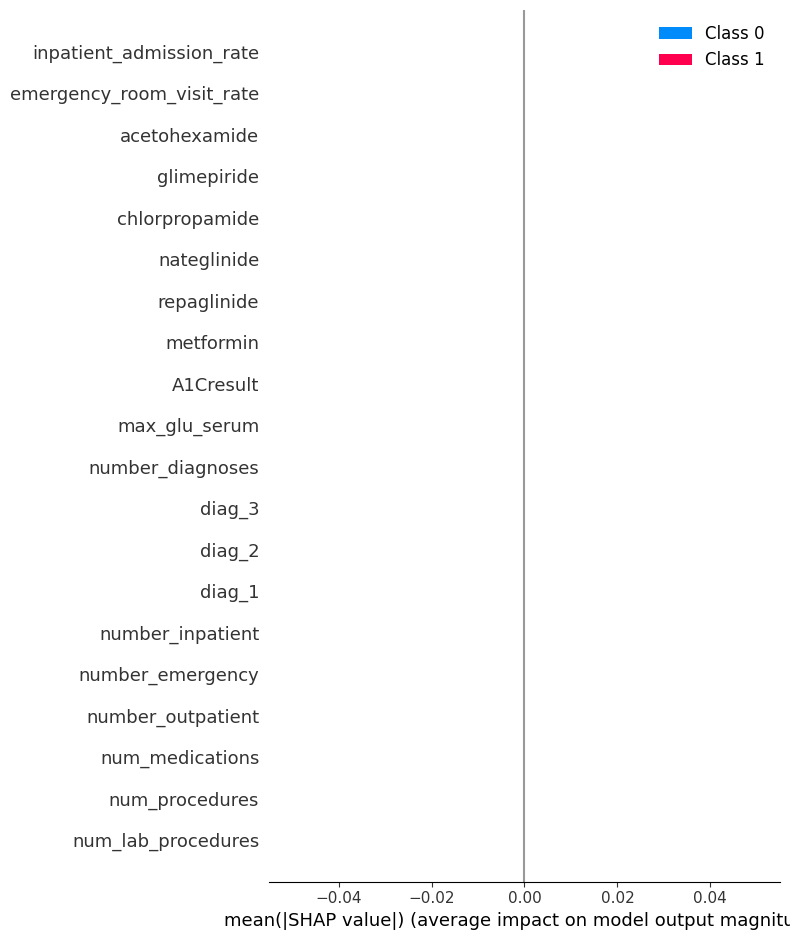

In [45]:
shap.summary_plot(shap_values, test_x)

In [ ]:
# Train a RandomForestRegressor (you can also use RandomForestClassifier for classification)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_x, train_y)
# Create a SHAP explainer using the RandomForest model
explainer = shap.Explainer(model, train_x)

# Calculate SHAP values for all features
shap_values = explainer(train_x)

# Plot SHAP summary plot
shap.summary_plot(shap_values, train_x, feature_names=data.feature_names)

  7%|=                   | 11014/160182 [47:17<640:22]       